In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [46]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = (x_train.astype(np.float32) / 255.0) * 2.0 - 1.0
x_test = (x_test.astype(np.float32) / 255.0) * 2.0 - 1.0
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

In [47]:
import tensorflow.keras.backend as K
import tensorflow as tf

def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=2.0))  # max_val=2.0 because [-1,1]


In [48]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Dense, Flatten, Reshape, BatchNormalization, Dropout
from tensorflow.keras.models import Model

input_img = Input(shape=(32, 32, 3))

# Encoder
x = Conv2D(32, 3, activation='relu', padding='same')(input_img)
x = MaxPooling2D(2, padding='same')(x)
x = BatchNormalization()(x)

x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(2, padding='same')(x)
x = BatchNormalization()(x)

x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(2, padding='same')(x)
x = Flatten()(x)

encoded = Dense(512, activation='relu')(x)
encoded = Dropout(0.3)(encoded)

# Classifier Head
classifier_output = Dense(10, activation='softmax', name='class_output')(encoded)

# Decoder
x = Dense(4 * 4 * 128, activation='relu')(encoded)
x = Reshape((4, 4, 128))(x)

x = Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)


In [49]:

# Final layer uses tanh
decoded = Conv2D(3, 3, activation='tanh', padding='same', name='recon_output')(x)

# Full model
autoencoder = Model(inputs=input_img, outputs=[decoded, classifier_output])
autoencoder.compile(
    optimizer='adam',
    loss={'recon_output': ssim_loss, 'class_output': 'categorical_crossentropy'},
    loss_weights={'recon_output': 0.4, 'class_output': 0.6},
    metrics={'recon_output': 'mse', 'class_output': 'accuracy'}
)

autoencoder.summary()



Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 32, 32,    │        896 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 16, 16,    │          0 │ conv2d_21[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        128 │ max_pooling2d_15… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 16, 16,    │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 8, 8, 64)  │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ max_pooling2d_16… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 8, 8, 128) │     73,856 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 4, 4, 128) │          0 │ conv2d_23[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 2048)      │          0 │ max_pooling2d_17… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 512)       │  1,049,088 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 512)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 2048)      │  1,050,624 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 4, 4, 128) │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_9  │ (None, 8, 8, 128) │    147,584 │ reshape_5[0][0]   │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_10 │ (None, 16, 16,    │     73,792 │ batch_normalizat… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_11 │ (None, 32, 32,    │     18,464 │ batch_normalizat

 Total params: 2,439,949 (9.31 MB)

 Trainable params: 2,439,373 (9.31 MB)

 Non-trainable params: 576 (2.25 KB)

In [50]:
# Then train with both outputs
autoencoder.fit(
    x_train,
    {'recon_output': x_train, 'class_output': y_train_cat},
    validation_data=(x_test, {'recon_output': x_test, 'class_output': y_test_cat}),
    epochs=30,
    batch_size=256,
    shuffle=True
)


Epoch 1/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 70s 283ms/step - class_output_accuracy: 0.3533 - class_output_loss: 2.0010 - loss: 1.5796 - recon_output_loss: 0.9474 - recon_output_mse: 0.4890 - val_class_output_accuracy: 0.1150 - val_class_output_loss: 4.4684 - val_loss: 3.0549 - val_recon_output_loss: 0.9536 - val_recon_output_mse: 0.2692
Epoch 2/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 57s 293ms/step - class_output_accuracy: 0.6073 - class_output_loss: 1.0997 - loss: 1.0102 - recon_output_loss: 0.8761 - recon_output_mse: 0.2674 - val_class_output_accuracy: 0.2554 - val_class_output_loss: 3.0373 - val_loss: 2.1748 - val_recon_output_loss: 0.8902 - val_recon_output_mse: 0.1791
Epoch 3/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 58s 297ms/step - class_output_accuracy: 0.6769 - class_output_loss: 0.9089 - loss: 0.8859 - recon_output_loss: 0.8514 - recon_output_mse: 0.2034 - val_class_output_accuracy: 0.6645 - val_class_output_loss: 0.9541 - val_loss: 0.9002 - val_recon_output_loss: 0.8242 - val_recon_output_mse: 0.

In [51]:
# Define encoder model for feature extraction
encoder = Model(inputs=input_img, outputs=encoded)
encoded_imgs = encoder.predict(x_train)

# Flatten encoded features
flattened = encoded_imgs.reshape(len(encoded_imgs), -1)

# Apply KMeans to flattened features
kmeans = KMeans(n_clusters=10, random_state=42)
cluster_labels = kmeans.fit_predict(flattened)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [52]:
from sklearn.metrics import silhouette_score

# Evaluate clustering performance
sil_score = silhouette_score(encoded_imgs, cluster_labels)
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.0634


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


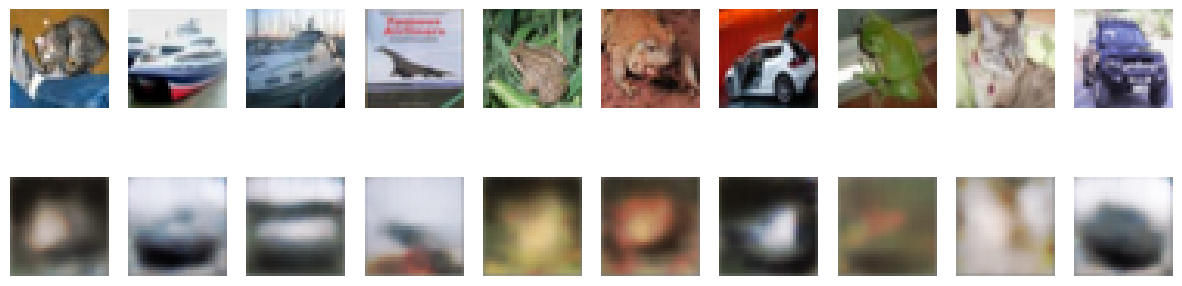

In [53]:
recons = autoencoder.predict(x_test[:10])[0]
recons = (recons + 1.0) / 2.0  # back to [0, 1]

# Plot
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    axes[0, i].imshow((x_test[i] + 1.0) / 2.0)  # Original unscaled
    axes[1, i].imshow(recons[i])               # Reconstructed
    axes[0, i].axis("off")
    axes[1, i].axis("off")
plt.show()



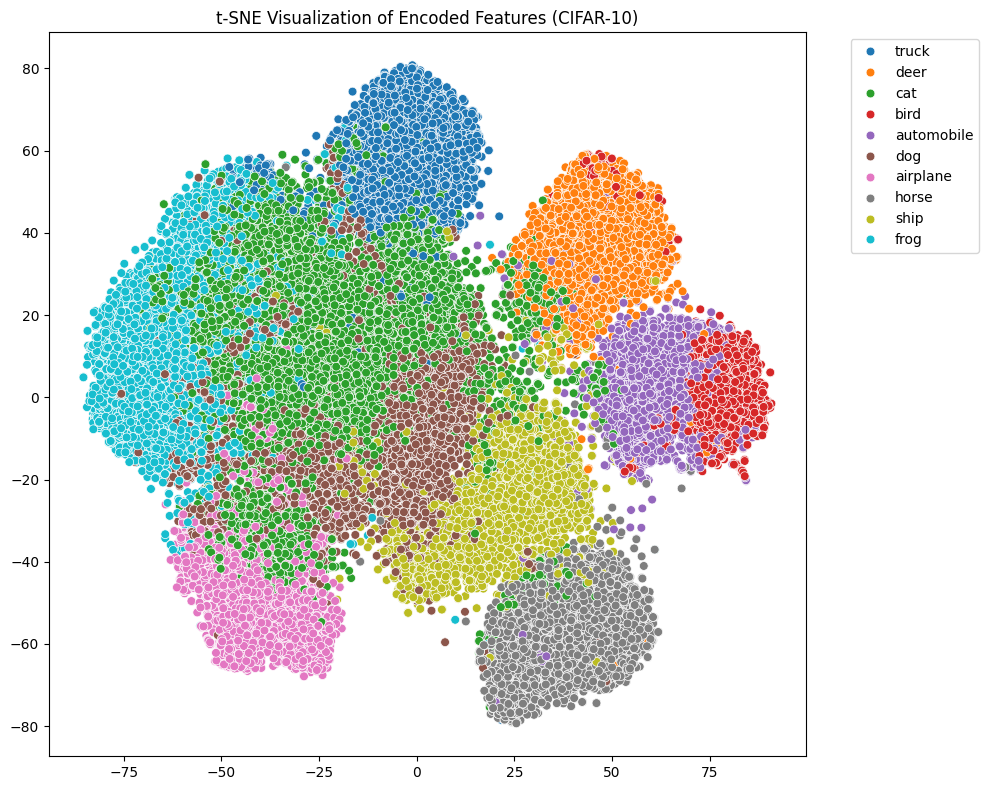

In [54]:
from sklearn.manifold import TSNE
import seaborn as sns

# Reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(flattened)

# CIFAR-10 label names
cifar10_labels = np.array([
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
])

# Convert numeric labels to readable names
named_labels = cifar10_labels[cluster_labels]  # Use cluster_labels from KMeans

# Plot with names
plt.figure(figsize=(10, 8))
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=named_labels, palette="tab10", s=40)
plt.title("t-SNE Visualization of Encoded Features (CIFAR-10)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [55]:
from tensorflow.keras.losses import MeanSquaredError

mse = MeanSquaredError()

decoded_imgs = autoencoder.predict(x_test)[0]
loss = mse(x_test, decoded_imgs).numpy()

print(f"Average MSE on test set: {loss:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Average MSE on test set: 0.1278
